In [2]:
import anndata as ad
import scanpy as sc
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dynchro

In [3]:
%load_ext autoreload
%autoreload 2

We will compare how the alignment of pseudocells compares with the alignment of the original cells.

In this usecase we look at the simulated data.

# 1. Preprocess data

In [4]:
d1 = ad.read_h5ad("data/dataseta2.h5ad")
d2 = ad.read_h5ad("data/datasetb2.h5ad")

d1.uns["iroot"] = np.flatnonzero(d1.obs["sim_time"] == 0.0)[5]
d2.uns["iroot"] = np.flatnonzero(d2.obs["sim_time"] == 0.0)[5]

d2 = d2[d2.obs["milestones"] != "sEndC", :]

d1, d2

(AnnData object with n_obs × n_vars = 5000 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
     uns: 'iroot', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions'
     obsm: 'dimred'
     layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts',
 View of AnnData object with n_obs × n_vars = 3132 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna',

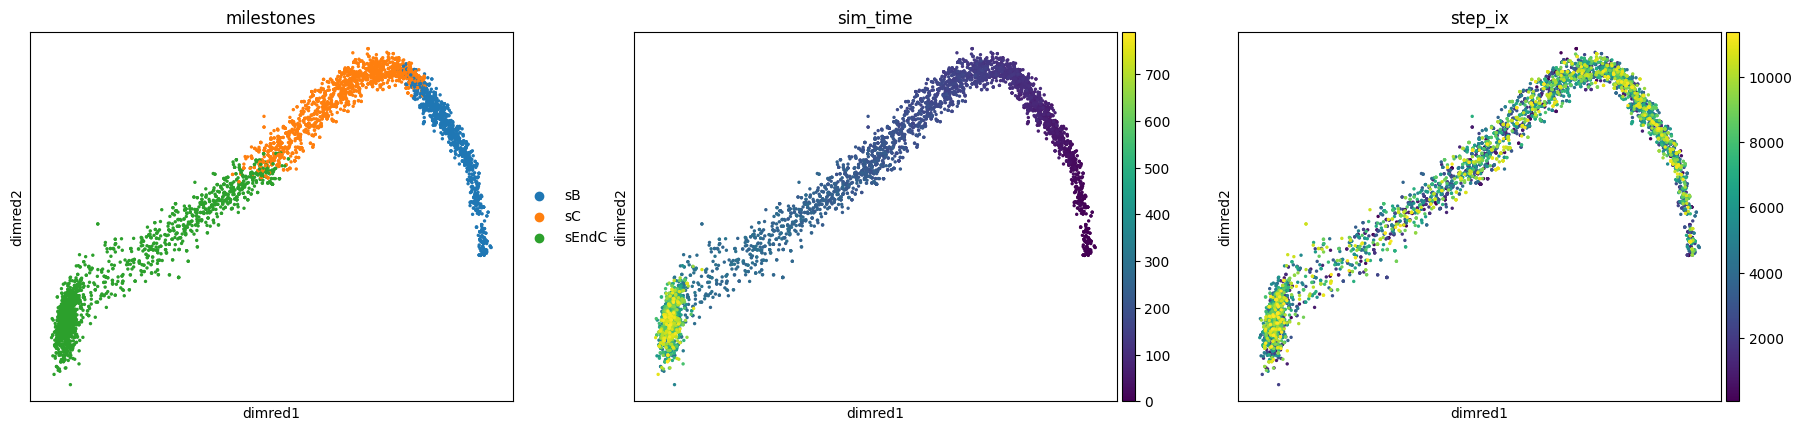

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


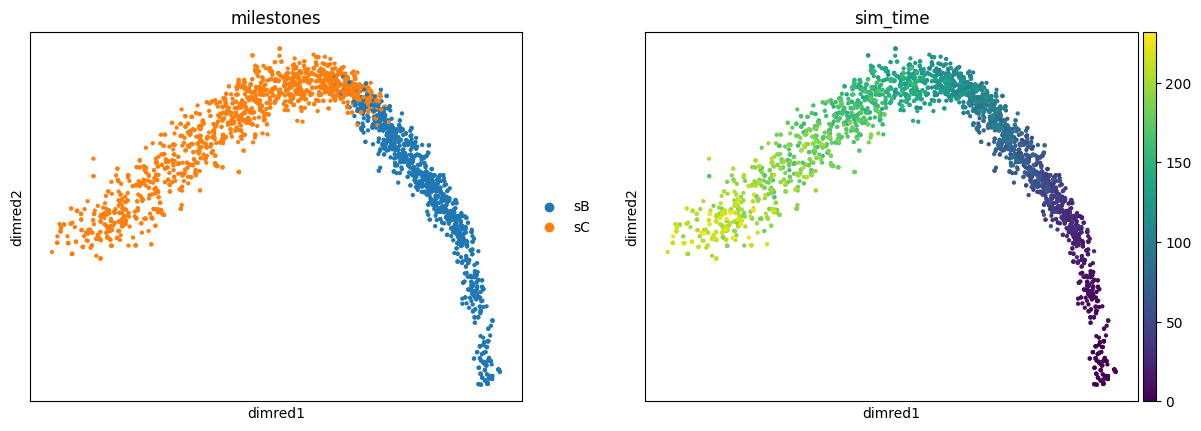

In [5]:
sc.pl.embedding(d1, basis = "dimred", color = ["milestones", "sim_time", "step_ix"])
sc.pl.embedding(d2, basis = "dimred", color = ["milestones", "sim_time"])

In [6]:
def preprocess(dataset):
    sc.pp.normalize_total(dataset, target_sum=1e4)
    sc.pp.log1p(dataset)
    sc.pp.pca(dataset)
    sc.pp.neighbors(dataset, n_neighbors=15)
    sc.tl.umap(dataset)
    sc.tl.leiden(dataset)
    return dataset

In [7]:
d1 = preprocess(d1)
d2 = preprocess(d2)

/tmp/ipykernel_230994/683822307.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(dataset)


In [8]:
# We run a trajectory inference method, dpt, in order to 

sc.tl.diffmap(d1)
sc.tl.diffmap(d2)

sc.tl.dpt(d1, n_dcs=10)
sc.tl.dpt(d2, n_dcs=10)
d1.obs["pseudotime"] = d1.obs["dpt_pseudotime"]
d2.obs["pseudotime"] = d2.obs["dpt_pseudotime"]

# argsort on pseudotime                                 
d1 = d1[np.argsort(d1.obs["pseudotime"]), :]
d2 = d2[np.argsort(d2.obs["pseudotime"]), :]

d1, d2

(View of AnnData object with n_obs × n_vars = 5000 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
     uns: 'iroot', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'milestones_colors', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'diffmap_evals'
     obsm: 'dimred', 'X_pca', 'X_umap', 'X_diffmap'
     varm: 'PCs'
     layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'
     obsp: 'distances', 'connectivities',
 View of AnnData object with n_obs × n_vars = 3132 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'pseudotime'
     var:

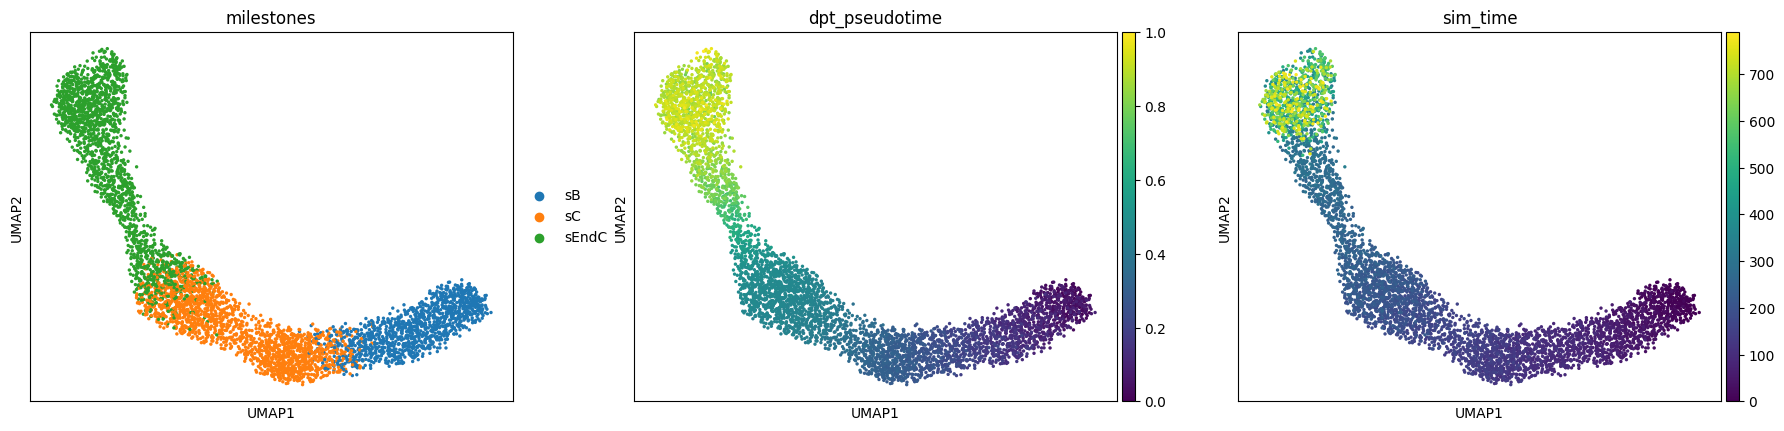

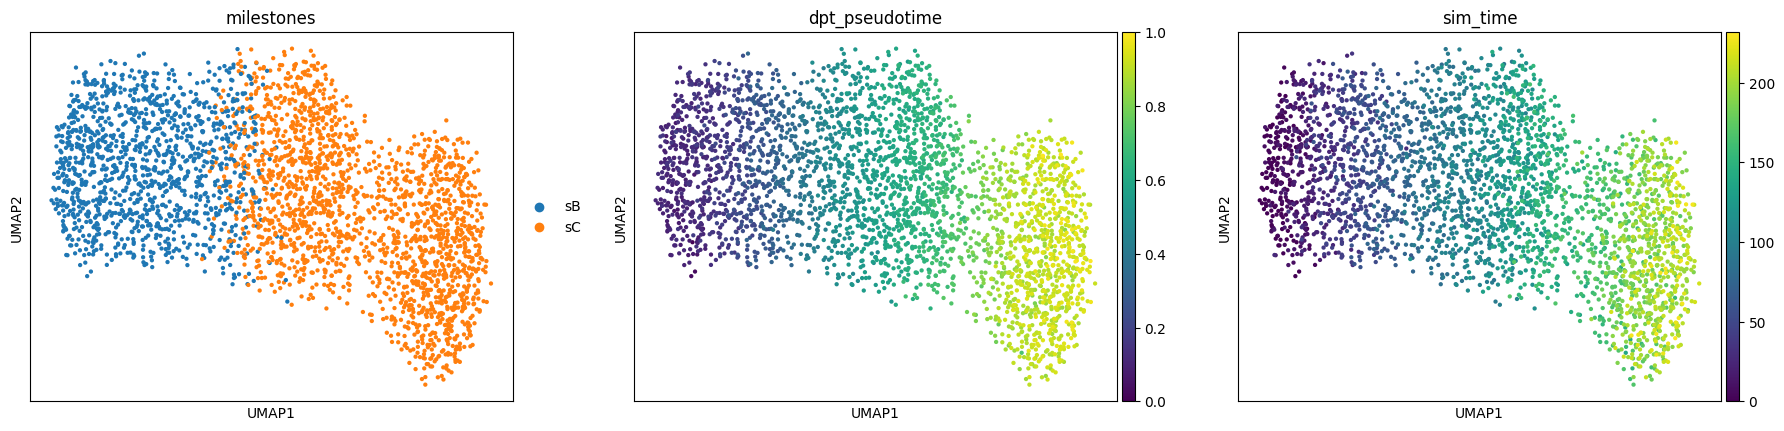

In [9]:
sc.pl.umap(d1, color=["milestones", "dpt_pseudotime", "sim_time"])
sc.pl.umap(d2, color=["milestones", "dpt_pseudotime", "sim_time"])

# 2. Generate pseudocells

After preprocessing the simulated datasets, we calculate the pseudocells. We generate about 100 pseudocells for each
dataset.

In [10]:
d1.obs["lineage"] = True
d2.obs["lineage"] = True

/tmp/ipykernel_230994/2224379973.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1.obs["lineage"] = True
/tmp/ipykernel_230994/2224379973.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2.obs["lineage"] = True


In [11]:
d1.obs["pseudotime"] = d1.obs["dpt_pseudotime"]
d2.obs["pseudotime"] = d2.obs["dpt_pseudotime"]

d1_ = dynchro.pp.calculate_pseudocells(d1, 100, "lineage")
d2_ = dynchro.pp.calculate_pseudocells(d2, 100, "lineage")

/home/louise/Work/dynchro/src/dynchro/pp/pseudocells.py:61: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"transition_matrix_{amount}"] = np.array(


In [12]:
pseudocells1 = d1_.varm["pseudocells_100_lineage"].T
pseudocells2 = d2_.varm["pseudocells_100_lineage"].T

pseudocell_pseudotimes1 = d1_.uns["pseudocells_100_lineage_pseudotime"]
pseudocell_pseudotimes2 = d2_.uns["pseudocells_100_lineage_pseudotime"]

d1_trans = d1_.uns["transition_matrix_100"]
d2_trans = d2_.uns["transition_matrix_100"]

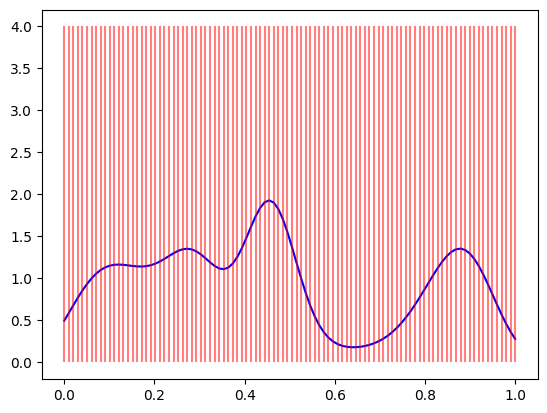

In [13]:
pseudotimes_kde_orig = sp.stats.gaussian_kde(d1.obs["pseudotime"])
x_values = np.linspace(0, 1, 100)
y_values = pseudotimes_kde_orig(x_values)
plt.plot(x_values, y_values, color = "blue")
plt.vlines(pseudocell_pseudotimes1.values, 0, 4, color = "red", alpha=0.5)

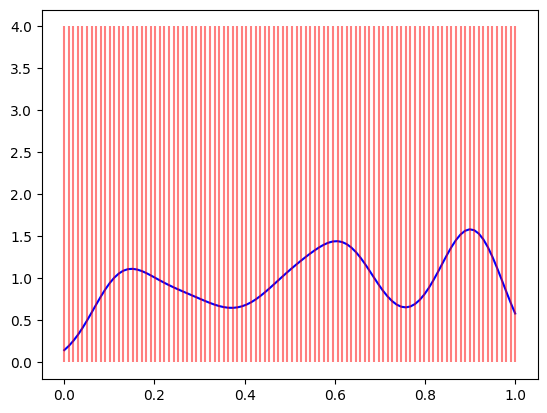

In [14]:
pseudotimes_kde_orig2 = sp.stats.gaussian_kde(d2.obs["pseudotime"])
x_values = np.linspace(0, 1, 100)
y_values = pseudotimes_kde_orig2(x_values)
plt.plot(x_values, y_values, color = "blue")
plt.vlines(pseudocell_pseudotimes2.values, 0, 4, color = "red", alpha=0.5)

Finally, we might want to check how many original cells contributed to each pseudocell. This to ensure that 

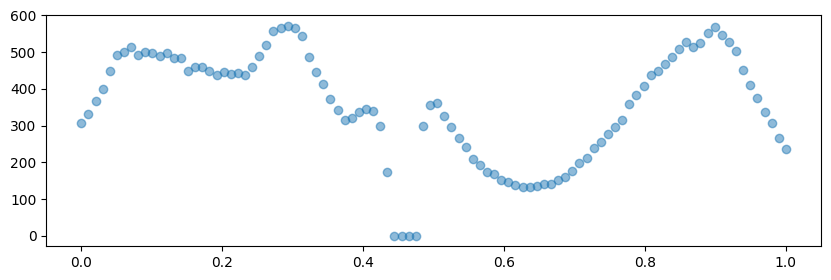

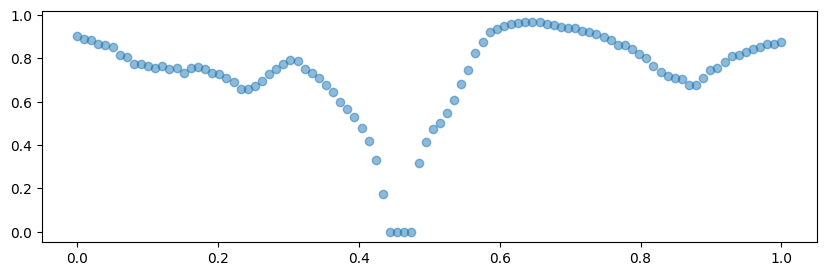

In [15]:
# get all contributions
threshold = 0.001
contributions = []
contributing_cells = []
for i in range(d1_trans.shape[0]):
    contributing_cells_part = d1_trans[i,:] >= threshold
    contributing_cells.append(contributing_cells_part)
    contribution = d1_trans[i,:][d1_trans[i, :] >= threshold]
    contributions.append((sum(contribution), len(contribution)))
    # contributing_cells.extend([i] * len(contribution))

# plot amount covered and number of cells contributing
plt.figure(figsize=(10, 3))
plt.scatter(pseudocell_pseudotimes1.values, [x[1] for x in contributions], alpha=0.5)
plt.show()
plt.figure(figsize=(10, 3))
plt.scatter(pseudocell_pseudotimes1.values, [x[0] for x in contributions], alpha=0.5)

# 3. Run DTW on pseudocells

Now we will run dynchro's alignment procedure on the pseudocells

In [16]:
d3 = ad.AnnData(X = pseudocells1, var = d1.var, obs = pd.DataFrame({"pseudotime": pseudocell_pseudotimes1}))
d4 = ad.AnnData(X = pseudocells2, var = d2.var, obs = pd.DataFrame({"pseudotime": pseudocell_pseudotimes2}))
d3, d4

(AnnData object with n_obs × n_vars = 100 × 522
     obs: 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein',
 AnnData object with n_obs × n_vars = 100 × 522
     obs: 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein')

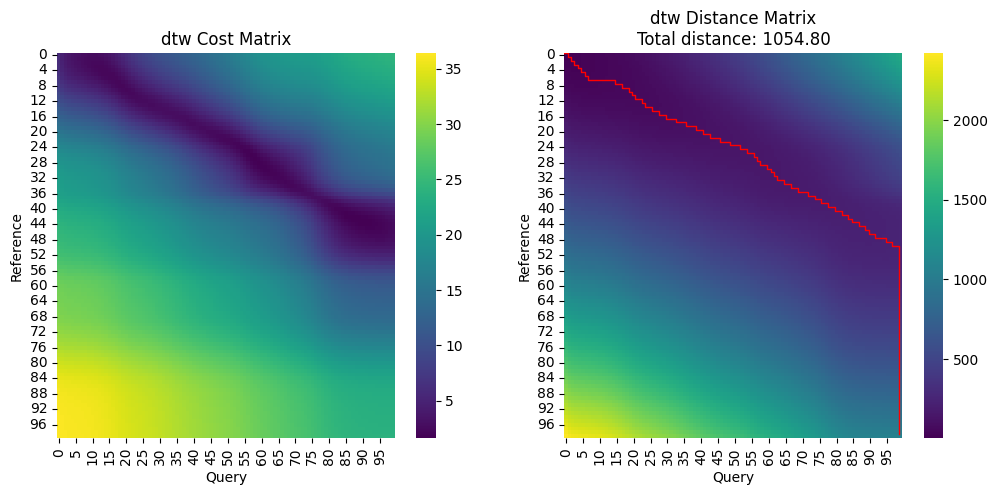

In [17]:
d3, d4 = dynchro.tl.dtw(d3, d4)
d3, d4 = dynchro.tl.traceback(d3, d4)

d4 = dynchro.tl.warp_pseudotime(d3, d4)
d3 = dynchro.tl.warp_pseudotime(d4, d3)

dynchro.pl.plot_dtw_matrices(d3, d4)

# 4. Run DTW on actual cells

Here we run dynchro's alignment procedure on the actual cells

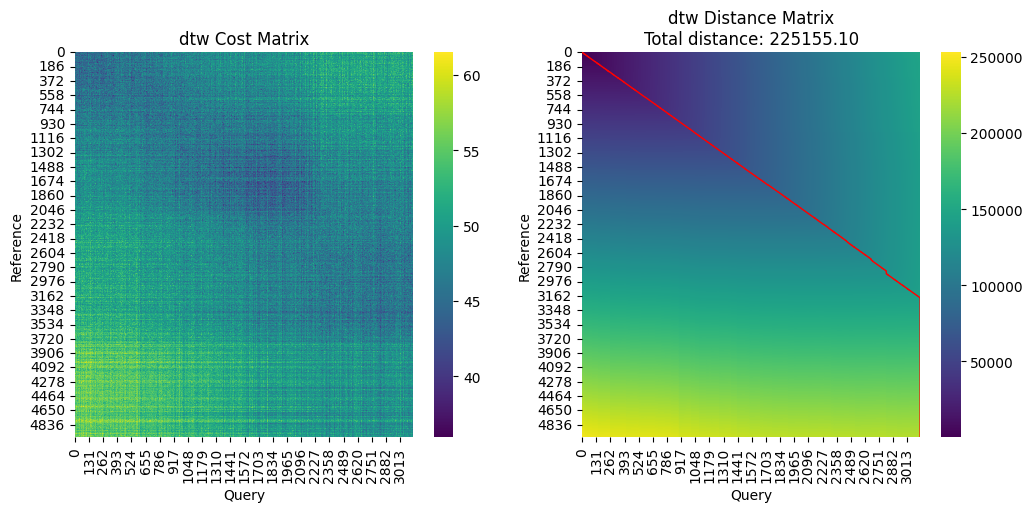

In [18]:
d1, d2 = dynchro.tl.dtw(d1, d2)
d1, d2 = dynchro.tl.traceback(d1, d2)

d2 = dynchro.tl.warp_pseudotime(d1, d2)
d1 = dynchro.tl.warp_pseudotime(d2, d1)

dynchro.pl.plot_dtw_matrices(d1, d2)


# 5. Compare warpings

Finally, we compare the warpings.

We do this by mapping back the pseudocell warpings to the actual dataset.

In [19]:
d1_mapped = dynchro.pp.map_back(d1, d3, d1_trans, "dtw_warped_pseudotime")
d2_mapped = dynchro.pp.map_back(d2, d4, d2_trans, "dtw_warped_pseudotime")

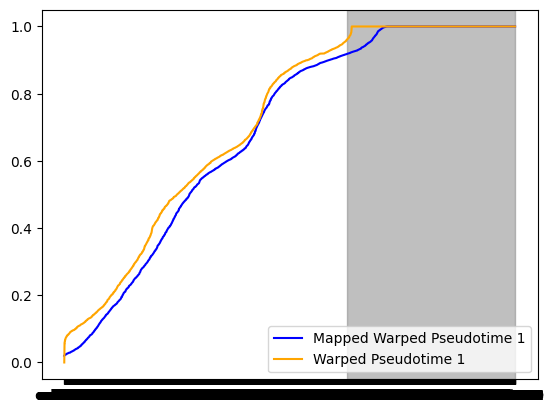

In [20]:
plt.plot(d1.obs["mapped_dtw_warped_pseudotime"], label="Mapped Warped Pseudotime 1", color='blue')
plt.plot(d1.obs["dtw_warped_pseudotime"], label="Warped Pseudotime 1", color='orange')

# plot square on x axis from end to end - 1868
plt.axvspan(5000-1868, 5000, color='gray', alpha=0.5)

plt.legend()

# 6. Figure

This code reproduces the figure in the paper exactly.

In [21]:
colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)

import numpy as np

def get_colors(colors, labels, color_map=None):
    if color_map is None:
        color_map = {label: colors[i] for i, label in enumerate(np.unique(labels))}
    translated_colors = np.array([color_map[c] for c in labels])

    handles, labels = get_color_legend(color_map)

    return translated_colors, handles, labels

def get_color_legend(color_map):
    handles = [
        plt.Line2D(
                [0], [0], marker='o', markerfacecolor=c, color = "k", 
                markersize = 7.5, lw = 0
            ) for c in color_map.values()
        ]
    labels = list(color_map.keys())
    return handles, labels

def plot_celltypes(adata, ax, legendax = None, flipy = False, colormap = None):
    xs = adata.obsm['X_umap'][:, 0]
    ys = adata.obsm['X_umap'][:, 1]

    if flipy:
        ys = -adata.obsm['X_umap'][:, 1]
    labels = adata.obs['milestones'].values

    translated_colors, handles, labels = get_colors(colors, labels, color_map=colormap)

    ax.scatter(xs, ys, c=translated_colors,  s=50, edgecolors = 'k')

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    # ax.set_xlabel("Flat tree plot", fontdict={'fontsize': 8})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.15, 0.1)
    ax.set_ylabel("")

    x0 = ax.get_xlim()[0]
    y0 = ax.get_ylim()[0]

    ax.annotate("", xy=(0.05, 0.35), xytext=(0.05, 0.04), xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle="->", color='k'))

    # ax.arrow(x0, y0, 3, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
    ax.set_xlabel("UMAP 1", fontsize=8)
    ax.xaxis.set_label_coords(0.15, 0.02)

    ax.annotate("", xy=(0.3, 0.05), xytext=(0.04, 0.05), xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle="->", color='k'))
    # ax.arrow(x0, y0, 0, 3, head_width=0.5, head_length=0.5, fc='k', ec='k')
    ax.set_ylabel("UMAP 2", fontsize=8)
    ax.yaxis.set_label_coords(0.04, 0.18)

    if legendax is not None:
        legendax.axis('off')
        legendax.legend(handles=handles, labels=labels, title="", loc='center', frameon=False, fontsize="x-small", title_fontsize="small")

    return ax

/tmp/ipykernel_230994/1395865381.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)


In [22]:
def flatten(values : list) -> list:
    """
    Flatten a list of lists into a single list.
    """
    flat_list = []

    for sublist in values:
        if isinstance(sublist, list):
            # If the item is a list, extend the result with its contents
            flat_list.extend(sublist)
        else:
            # If the item is not a list, append it directly if it is not None
            if sublist is not None:
                flat_list.append(sublist)

    return flat_list


def plot_matrix(matrix, axes, xticks, yticks, pathx, pathy):
    im = axes[0].imshow(matrix, cmap='viridis', aspect='auto')
    # axes.set_title(title)
    axes[0].set_xticks(xticks)
    axes[0].set_yticks(yticks)

    # plot colorbar
    fig.colorbar(im, ax=axes[0], pad=0.1)
    # plt.colorbar(im, ax=axes[1], fraction=0.75, shrink=0.75)
    path1 = flatten(pathx) #flatten(reference.obs[f"{dtw_key}_path"])
    path2 = flatten(pathy) #flatten(query.obs[f"{dtw_key}_path"])

    axes[0].plot(path1, path2, color='red', linewidth=1)

In [29]:
def plot_comparisons(data, ax, square = None):
    xs = data.obs["pseudotime"].values
    ys1 = data.obs["mapped_dtw_warped_pseudotime"].values
    ys2 = data.obs["dtw_warped_pseudotime"].values

    if square:
        ax.axvspan(square[0], square[1], color=colors[7], alpha=0.5)        

    ax.plot(xs, ys2, label="Original", color=colors[0])
    ax.plot(xs, ys1, label="Pseudocells", color=colors[1])
    ax.set_xlabel("Pseudotime", fontsize=8)
    ax.set_ylabel("Warped Pseudotime", fontsize=8)
    # ax.legend()


In [24]:
def plot_pseudocells(data, ax):
    pseudotimes_kde_orig = sp.stats.gaussian_kde(data.obs["pseudotime"])
    x_values = np.linspace(0, 1, 100)
    y_values = pseudotimes_kde_orig(x_values)
    
    ax.vlines(x_values, 0, 2.1, color = colors[1], alpha=1, lw = 0.5)
    ax.plot(x_values, y_values, color = colors[0])
    # print(y_values)


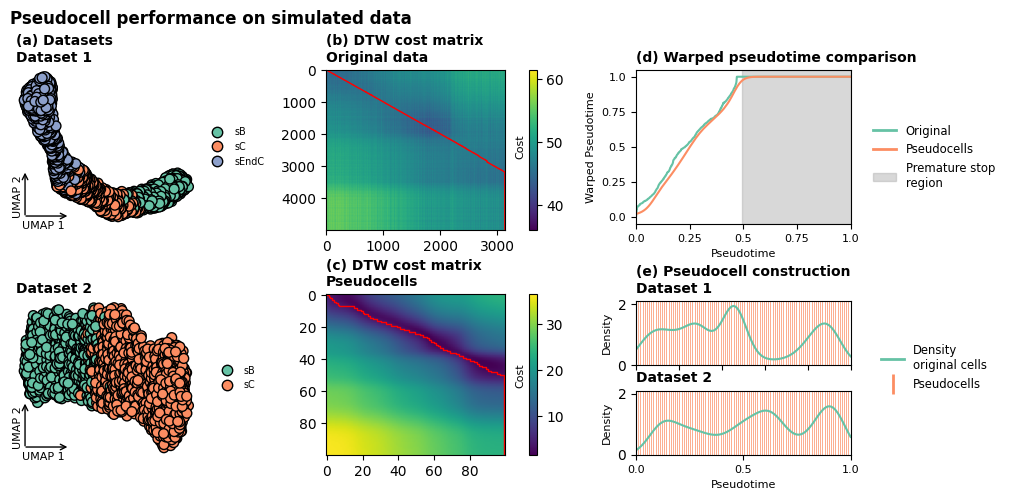

In [31]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Pseudocell performance on simulated data", fontsize=12, fontweight='bold', x=0.12, y=1, horizontalalignment='left')
gs_outer = fig.add_gridspec(2, 4, width_ratios = [1,1,0.9, 0.1], height_ratios = [1,1], hspace=0.5, wspace = 0.4)

gsa = gs_outer[0, 0].subgridspec(1, 2, width_ratios=[1, 0.2])
axa1, axa2 = gsa.subplots()
gsb = gs_outer[1, 0].subgridspec(1, 2, width_ratios=[1, 0.2])
axb1, axb2 = gsb.subplots()
# (axa, axb), (axc, axd), (axe, axf) = gs_outer.subplots()

plot_celltypes(d1, axa1, legendax=axa2)
plot_celltypes(d2, axb1, legendax=axb2)
axa1.set_title("(a) Datasets\nDataset 1", fontsize=10, fontweight='bold', loc='left')
axb1.set_title("Dataset 2", fontsize=10, fontweight='bold', loc='left')

axc, axd = gs_outer[:, 1].subgridspec(2, 1, hspace=0.4).subplots()

# axc = gs_outer[0, 1].subgridspec(1, 1).subplots()
# axd = gs_outer[1, 1].subgridspec(1, 1).subplots()

xticks0 = [0, 1000, 2000, 3000, 4000, 5000]
yticks0 = [0, 1000, 2000, 3000, 4000, 5000]

xticks1 = [0, 20, 40, 60, 80, 100]
yticks1 = [0, 20, 40, 60, 80, 100]

plot_matrix(d1.obsm['dtw_cost'], (axc,), xticks=xticks0, yticks=yticks0, pathx=d1.obs["dtw_path"], pathy=d2.obs["dtw_path"])
axc.text(3400, 2700, "Cost", rotation=90, horizontalalignment='center', fontsize=8)
plot_matrix(d3.obsm['dtw_cost'], (axd,), xticks=xticks1, yticks=yticks1, pathx=d3.obs["dtw_path"], pathy=d4.obs["dtw_path"])
axd.text(108, 50, "Cost", rotation=90, horizontalalignment='center', verticalalignment='center', fontsize=8)

axc.set_title("(b) DTW cost matrix\nOriginal data", fontsize=10, fontweight='bold', loc='left')
axd.set_title("(c) DTW cost matrix\nPseudocells", fontsize=10, fontweight='bold', loc='left')

axe = gs_outer[0, 2].subgridspec(1, 1).subplots()
plot_comparisons(d1, ax=axe, square = [max(d1[d1.obs.milestones != "sEndC", :].obs.pseudotime), 1.0])
# plot_comparisons(d2, ax=axe[1])
axe.set_title("(d) Warped pseudotime comparison", fontsize=10, fontweight='bold', loc='left')
axe.margins(0, 0.05)
axe.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
axe.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
axe.set_xticklabels([0.0, 0.25, 0.5, 0.75, 1.0], fontdict={'fontsize': 8})
axe.set_yticklabels([0.0, 0.25, 0.5, 0.75, 1.0], fontdict={'fontsize': 8})

axf, axg = gs_outer[1, 2].subgridspec(2, 1, hspace=0.4).subplots()

plot_pseudocells(d1, axf)
plot_pseudocells(d2, axg)

axf.set_xticklabels([])
axf.margins(0, 0)
axg.set_xticks([0, 0.5, 1.0])
axg.set_xticklabels(axg.get_xticklabels(), fontdict={'fontsize': 8})
# axg.set_yticklabels(axg.get_yticklabels(), fontdict={'fontsize': 8})
axg.set_yticks([0, 2])
# axg.set_yticklabels(axg.get_yticklabels(), fontdict={'fontsize': 8})
axg.margins(0, 0)

axg.set_xlabel("Pseudotime", fontsize=8)
axf.set_ylabel("Density", fontsize=8)
axg.set_ylabel("Density", fontsize=8)

axf.set_title("(e) Pseudocell construction\nDataset 1", fontsize=10, fontweight='bold', loc='left')
axg.set_title("Dataset 2", fontsize=10, fontweight='bold', loc='left')

axh, axi = gs_outer[:, 3].subgridspec(2, 1).subplots()
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=2),
    plt.Line2D([0], [0], color=colors[1], lw=2),
    plt.Rectangle((0,0),1,1, color=colors[7], alpha=0.5)
]
labels = ["Original", "Pseudocells", "Premature stop\nregion"]
axh.axis('off')
axh.legend(handles=handles, labels=labels, title="", loc='center', frameon=False, fontsize="small")

handles = [
    plt.Line2D([0], [0], color=colors[0], lw=2),
    plt.Line2D([0], [0], marker = "|", color=colors[1], lw=0, markersize=15, markeredgewidth=2)
]
labels = ["Density\noriginal cells", "Pseudocells"]
axi.axis('off')
axi.legend(handles=handles, labels=labels, title="", loc='center', frameon=False, fontsize="small")

plt.savefig("figures/figure_4_simulated_data.pdf", bbox_inches='tight', dpi=300)
plt.savefig("figures/figure_4_simulated_data.png", bbox_inches='tight', dpi=300)